<a href="https://colab.research.google.com/github/SamTremblay18/Hockey-Shot-Classification/blob/main/1_Preprocessing_%2B_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟢  Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import torch
from google.colab import drive 
drive.mount('/content/drive')
import pickle
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from keras import layers 
from keras import models
from sklearn.model_selection import train_test_split
from keras import regularizers

from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop


from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Mounted at /content/drive


# 🟢 Functions

In [2]:
#~~~~~~~~~~~~~~~~~~~~~ Function to load the acceleration and markers sheet from the Xsens excel file ~~~~~~~~~~~~~~~~~~~~~

def load_data(fpath):
  P_acc = pd.read_excel(fpath,sheet_name='Sensor Free Acceleration',  usecols = 'A,B,C,D,N,O,P,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN,AO,AP,AQ,AR,AS,AT,AU,AV,AW,AX,AY,AZ,BA,BB,BC,BG,BH,BI,BJ,BK,BL,BM,BN,BO,BS')
  P_markers = pd.read_excel(fpath,sheet_name='Markers',  usecols ='B,C,D')
  
  return P_acc, P_markers

#~~~~~~~~~~~~~~~~~~~~~ Function to regroup all the Pre, SH and post task together ~~~~~~~~~~~~~~~~~~~~~

def regroup_other(P_markers,P_acc):
  for i in range(0,len(P_markers.iloc[:,0])):
    
    length_trial = P_markers.iloc[i,2] # Frame length of a trial
    start_trial = P_markers.iloc[i,0]
   
    if P_markers.iloc[i,1] == 'Pre' or P_markers.iloc[i,1] == 'SH' or P_markers.iloc[i,1] == 'post':
      P_acc.loc[(start_trial):(start_trial)+((length_trial)-1),'Label'] = 'Other'

  return P_acc

#~~~~~~~~~~~~~~~~~~~~~ Function to put the shooting trials all the same frame length ~~~~~~~~~~~~~~~~~~~~~

def reframe(P_markers,P_acc):
  for i in range(0,len(P_markers.iloc[:,0])):

    length_trial = P_markers.iloc[i,2]
    start_trial = P_markers.iloc[i,0]
    type_shot = P_markers.iloc[i,1]

    if P_markers.iloc[i,1] == 'BH' or P_markers.iloc[i,1] == 'Pass' or P_markers.iloc[i,1] == 'SS' or P_markers.iloc[i,1] == 'WS' or P_markers.iloc[i,1] == 'OT':
        diff = int(576-length_trial) # Identifying how many frames are missing to have a length of 576
        P_acc.iloc[int(start_trial)-diff:int(start_trial)+int(length_trial),52] = type_shot # Adding the new labels to the 'Label' column

  return P_acc

#~~~~~~~~~~~~~~~~~~~~~ Function to save the dataframe into a pickle file ~~~~~~~~~~~~~~~~~~~~~

def save_pickle(path_pickle,P):
  f = open(path_pickle, 'wb')
  pickle.dump(P, f)
  f.close()

  return f 

#~~~~~~~~~~~~~~~~~~~~~ Function to open the dataframe from the pickle file ~~~~~~~~~~~~~~~~~~~~~

def open_pickle(path_pickle):
  f = open(path_pickle, 'rb')
  P = pickle.load(f)
  f.close()

  return P

#~~~~~~~~~~~~~~~~~~~~~ Function to encode the labels ~~~~~~~~~~~~~~~~~~~~~

def label_encoder(P_acc):
  le = LabelEncoder()
  P_acc['Label'] = le.fit_transform(P_acc['Label'])

  return P_acc

#~~~~~~~~~~~~~~~~~~~~~ Function to standardize the dataframe ~~~~~~~~~~~~~~~~~~~~~

def P_standardize(P_acc):
  P_acc_stand_all = pd.DataFrame()
  for i in range(1, 52):
    mu = np.mean(P_acc.iloc[:,i],axis = 0)
    sigma = np.std(P_acc.iloc[:,i],axis = 0)
    P_acc_stand = (P_acc.iloc[:,i] - mu)/sigma
    P_acc_stand_all = pd.concat([P_acc_stand_all, P_acc_stand],axis=1)
  P_acc_stand_all = pd.concat([P_acc_stand_all, P_acc.iloc[:,52]],axis=1)
    
  return P_acc_stand_all 

#~~~~~~~~~~~~~~~~~~~~~ Function to create tensors of shape 576 ~~~~~~~~~~~~~~~~~~~~~

def create_tensor(P_acc):
  trials_length = len(P_acc)/576
  T = np.stack(np.split(P_acc.values, trials_length), axis=1)
  Tensors = tf.constant(T.astype('float32'))

  return Tensors

#~~~~~~~~~~~~~~~~~~~~~ Function to create 15 trials of 'Other' ~~~~~~~~~~~~~~~~~~~~~

def other_class(P_other):
  num_list = random.sample(range(0,len(P_other),576),15)
  Other_all = pd.DataFrame()
  for i in num_list:
    other = P_other.iloc[i:(i+576),:]
    Other_all = pd.concat([Other_all, other], ignore_index = True)

  return Other_all

#~~~~~~~~~~~~~~~~~~~~~ Function that runs all the preprocessing steps ~~~~~~~~~~~~~~~~~~~~~

def Preprocess(P_markers, P_acc):
  P_data = regroup_other(P_markers,P_acc)
  P_data = reframe(P_markers,P_data)
  P_other = P_data[(P_data['Label'] == 'Other')]
  P_other_all = other_class(P_other)
  P_data = P_data.drop(P_data[(P_data['Label'] == 'Do not use')].index)
  P_data = P_data.drop(P_data[(P_data['Label'] == 'Other')].index)
  P_data = pd.concat([P_data, P_other_all], ignore_index = True)
  P_data = P_standardize(P_data)
  P_data = label_encoder(P_data)
  P_data = create_tensor(P_data)
  
  return P_data



In [3]:
#~~~~~~~~~~~~~~~~~~~~~ Function to shuffle the tensors ~~~~~~~~~~~~~~~~~~~~~
def tf_shuffle_axis(value, axis=0, seed=None):
    perm = list(range(tf.rank(value)))
    perm[axis], perm[0] = perm[0], perm[axis]
    value = tf.random.shuffle(tf.transpose(value, perm=perm))
    value = tf.transpose(value, perm=perm)
    return value

#~~~~~~~~~~~~~~~~~~~~~ CNN model ~~~~~~~~~~~~~~~~~~~~~

def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
    #Instantiating convnet
    model = models.Sequential()
    #filter size: 32, kernel of 3, input shape without the batch_size (one trial), padding= with zero padding
    model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu', input_shape=(input_size),padding='same')) 

    model.add(layers.MaxPooling1D(pool_size))
    model.add(layers.Conv1D(filter_numb2, kernel_size,activation='relu',padding='same'))
    model.add(layers.Conv1D(filter_numb2, kernel_size,activation='relu',padding='same'))
    # model.summary()

    #Adding a classifier on top of the convnet
    model.add(layers.Flatten()) 
    model.add(layers.Dense(filter_numb3, activation='relu')) 
    model.add(layers.Dense(7, activation='softmax')) 
    # model.summary()

    model.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model 

#  🛑 Opening participants' dataset and pickle saving

In [ ]:
# P01
P01_acc, P01_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P01_SensFreeAcc.xlsx')
f1_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P01_acc.pickle',P01_acc)
f1_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P01_markers.pickle',P01_markers)
# P02
P02_acc, P02_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P02_SensFreeAcc.xlsx')
f2_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P02_acc.pickle',P02_acc)
f2_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P02_markers.pickle',P02_markers)
# P03
P03_acc, P03_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P03_SensFreeAcc.xlsx')
f3_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P03_acc.pickle',P03_acc)
f3_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P03_markers.pickle',P03_markers)
# P04
P04_acc, P04_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P04_SensFreeAcc.xlsx')
f4_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P04_acc.pickle',P04_acc)
f4_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P04_markers.pickle',P04_markers)
# P05
P05_acc, P05_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P05_SensFreeAcc.xlsx')
f5_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P05_acc.pickle',P05_acc)
f5_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P05_markers.pickle',P05_markers)
# P07
P07_acc, P07_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P07_SensFreeAcc.xlsx')
f7_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P07_acc.pickle',P07_acc)
f7_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P07_markers.pickle',P07_markers)
# P08
P08_acc, P08_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P08_SensFreeAcc.xlsx')
f8_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P08_acc.pickle',P08_acc)
f8_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P08_markers.pickle',P08_markers)
# P09
P09_acc, P09_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P09_SensFreeAcc.xlsx')
f9_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P09_acc.pickle',P09_acc)
f9_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P09_markers.pickle',P09_markers)
# P10
P10_acc, P10_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P10_SensFreeAcc.xlsx')
f10_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P10_acc.pickle',P10_acc)
f10_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P10_markers.pickle',P10_markers)
# P11
P11_acc, P11_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P11_SensFreeAcc.xlsx')
f11_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P11_acc.pickle',P11_acc)
f11_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P11_markers.pickle',P11_markers)
# P12
P12_acc, P12_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P12_SensFreeAcc.xlsx')
f12_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P12_acc.pickle',P12_acc)
f12_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P12_markers.pickle',P12_markers)
# P13
P13_acc, P13_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P13_SensFreeAcc.xlsx')
f13_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P13_acc.pickle',P13_acc)
f13_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P13_markers.pickle',P13_markers)
# P14
P14_acc, P14_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P14_SensFreeAcc.xlsx')
f14_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P14_acc.pickle',P14_acc)
f14_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P14_markers.pickle',P14_markers)
# P15
P15_acc, P15_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P15_SensFreeAcc.xlsx')
f15_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P15_acc.pickle',P15_acc)
f15_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P15_markers.pickle',P15_markers)
# 16
P16_acc, P16_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P16_SensFreeAcc.xlsx')
f16_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P16_acc.pickle',P16_acc)
f16_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P16_markers.pickle',P16_markers)
# P17
P17_acc, P17_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P17_SensFreeAcc.xlsx')
f17_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P17_acc.pickle',P17_acc)
f17_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P17_markers.pickle',P17_markers)
# P19
P19_acc, P19_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P19_SensFreeAcc.xlsx')
f19_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P19_acc.pickle',P19_acc)
f19_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P19_markers.pickle',P19_markers)
# P20
P20_acc, P20_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P20_SensFreeAcc.xlsx')
f20_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P20_acc.pickle',P20_acc)
f20_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P20_markers.pickle',P20_markers)
# P21
P21_acc, P21_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P21_SensFreeAcc.xlsx')
f21_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P21_acc.pickle',P21_acc)
f21_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P21_markers.pickle',P21_markers)
# P22
P22_acc, P22_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P22_SensFreeAcc.xlsx')
f22_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P22_acc.pickle',P22_acc)
f22_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P22_markers.pickle',P22_markers)
# P23
P23_acc, P23_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P23_SensFreeAcc.xlsx')
f23_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P23_acc.pickle',P23_acc)
f23_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P23_markers.pickle',P23_markers)
# P24
P24_acc, P24_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P24_SensFreeAcc.xlsx')
f24_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P24_acc.pickle',P24_acc)
f24_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P24_markers.pickle',P24_markers)
# P25
P25_acc, P25_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P25_SensFreeAcc.xlsx')
f25_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P25_acc.pickle',P25_acc)
f25_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P25_markers.pickle',P25_markers)
# P27
P27_acc, P27_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P27_SensFreeAcc.xlsx')
f27_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P27_acc.pickle',P27_acc)
f27_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P27_markers.pickle',P27_markers)
# P28
P28_acc, P28_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P28_SensFreeAcc.xlsx')
f28_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P28_acc.pickle',P28_acc)
f28_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P28_markers.pickle',P28_markers)
# P29
P29_acc, P29_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P29_SensFreeAcc.xlsx')
f29_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P29_acc.pickle',P29_acc)
f29_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P29_markers.pickle',P29_markers)
# P32
P32_acc, P32_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P32_SensFreeAcc.xlsx')
f32_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P32_acc.pickle',P32_acc)
f32_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P32_markers.pickle',P32_markers)
# P33
P33_acc, P33_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P33_SensFreeAcc.xlsx')
f33_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P33_acc.pickle',P33_acc)
f33_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P33_markers.pickle',P33_markers)
# P34
P34_acc, P34_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P34_SensFreeAcc.xlsx')
f34_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P34_acc.pickle',P34_acc)
f34_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P34_markers.pickle',P34_markers)
# P36
P36_acc, P36_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P36_SensFreeAcc.xlsx')
f36_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P36_acc.pickle',P36_acc)
f36_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P36_markers.pickle',P36_markers)
# P37
P37_acc, P37_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P37_SensFreeAcc.xlsx')
f37_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P37_acc.pickle',P37_acc)
f37_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P37_markers.pickle',P37_markers)
# 39
P39_acc, P39_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P39_SensFreeAcc.xlsx')
f39_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P39_acc.pickle',P39_acc)
f39_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P39_markers.pickle',P39_markers)
# P40
P40_acc, P40_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P40_SensFreeAcc.xlsx')
f40_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P40_acc.pickle',P40_acc)
f40_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P40_markers.pickle',P40_markers)
# P41
P41_acc, P41_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P41_SensFreeAcc.xlsx')
f41_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P41_acc.pickle',P41_acc)
f41_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P41_markers.pickle',P41_markers)
# P42
P42_acc, P42_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P42_SensFreeAcc.xlsx')
f42_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P42_acc.pickle',P42_acc)
f42_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P42_markers.pickle',P42_markers)
# P43
P43_acc, P43_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P43_SensFreeAcc.xlsx')
f43_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P43_acc.pickle',P43_acc)
f43_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P43_markers.pickle',P43_markers)

In [ ]:
# P26
P26_acc, P26_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P26_SensFreeAcc.xlsx')
f26_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P26_acc.pickle',P26_acc)
f26_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P26_markers.pickle',P26_markers)
# P35
P35_acc, P35_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P35_SensFreeAcc.xlsx')
f35_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P35_acc.pickle',P35_acc)
f35_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P35_markers.pickle',P35_markers)

In [ ]:
# P18
P18_acc, P18_markers = load_data('/content/drive/MyDrive/Sam/Labelled Data/P18_SensFreeAcc.xlsx')
f18_acc = save_pickle('/content/drive/MyDrive/Sam/File_saved/P18_acc.pickle',P18_acc)
f18_markers = save_pickle('/content/drive/MyDrive/Sam/File_saved/P18_markers.pickle',P18_markers)

# 🛑 Preprocessing each participants


In [5]:
# P01
P01_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P01_acc.pickle')
P01_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P01_markers.pickle')
P01 = Preprocess(P01_markers,P01_acc)
f1 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P01.pickle',P01)
# P02
P02_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P02_acc.pickle')
P02_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P02_markers.pickle')
P02 = Preprocess(P02_markers,P02_acc)
f2 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P02.pickle',P02)
# P03
P03_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P03_acc.pickle')
P03_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P03_markers.pickle')
P03 = Preprocess(P03_markers,P03_acc)
f3 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P03.pickle',P03)
# P04
P04_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P04_acc.pickle')
P04_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P04_markers.pickle')
P04 = Preprocess(P04_markers,P04_acc)
f4 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P04.pickle',P04)
# P05
P05_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P05_acc.pickle')
P05_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P05_markers.pickle')
P05 = Preprocess(P05_markers,P05_acc)
f5 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P05.pickle',P05)

In [ ]:
# P07
P07_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P07_acc.pickle')
P07_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P07_markers.pickle')
P07 = Preprocess(P07_markers,P07_acc)
f7 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P07.pickle',P07)
# P08
P08_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P08_acc.pickle')
P08_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P08_markers.pickle')
P08 = Preprocess(P08_markers,P08_acc)
f8 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P08.pickle',P08)
# P09
P09_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P09_acc.pickle')
P09_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P09_markers.pickle')
P09 = Preprocess(P09_markers,P09_acc)
f9 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P09.pickle',P09)
# P11
P11_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P11_acc.pickle')
P11_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P11_markers.pickle')
P11 = Preprocess(P11_markers,P11_acc)
f11 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P11.pickle',P11)
# P12
P12_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P12_acc.pickle')
P12_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P12_markers.pickle')
P12 = Preprocess(P12_markers,P12_acc)
f12 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P12.pickle',P12)

In [ ]:
# P13
P13_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P13_acc.pickle')
P13_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P13_markers.pickle')
P13 = Preprocess(P13_markers,P13_acc)
f13 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P13.pickle',P13)
# P14
P14_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P14_acc.pickle')
P14_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P14_markers.pickle')
P14 = Preprocess(P14_markers,P14_acc)
f14 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P14.pickle',P14)
# P15
P15_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P15_acc.pickle')
P15_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P15_markers.pickle')
P15 = Preprocess(P15_markers,P15_acc)
f15 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P15.pickle',P15)
# P16
P16_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P16_acc.pickle')
P16_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P16_markers.pickle')
P16 = Preprocess(P16_markers,P16_acc)
f16 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P16.pickle',P16)
# P17
P17_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P17_acc.pickle')
P17_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P17_markers.pickle')
P17 = Preprocess(P17_markers,P17_acc)
f17 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P17.pickle',P17)
# P18
P18_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P18_acc.pickle')
P18_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P18_markers.pickle')
P18 = Preprocess(P18_markers,P18_acc)
f18 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P18.pickle',P18)
# P19
P19_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P19_acc.pickle')
P19_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P19_markers.pickle')
P19 = Preprocess(P19_markers,P19_acc)
f19 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P19.pickle',P19)

In [ ]:
# P20
P20_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P20_acc.pickle')
P20_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P20_markers.pickle')
P20 = Preprocess(P20_markers,P20_acc)
f20 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P20.pickle',P20)
# P21
P21_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P21_acc.pickle')
P21_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P21_markers.pickle')
P21 = Preprocess(P21_markers,P21_acc)
f21 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P21.pickle',P21)
# P22
P22_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P22_acc.pickle')
P22_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P22_markers.pickle')
P22 = Preprocess(P22_markers,P22_acc)
f22 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P22.pickle',P22)
# P23
P23_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P23_acc.pickle')
P23_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P23_markers.pickle')
P23 = Preprocess(P23_markers,P23_acc)
f23 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P23.pickle',P23)
# P24
P24_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P24_acc.pickle')
P24_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P24_markers.pickle')
P24 = Preprocess(P24_markers,P24_acc)
f24 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P24.pickle',P24)
# P25
P25_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P25_acc.pickle')
P25_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P25_markers.pickle')
P25 = Preprocess(P25_markers,P25_acc)
f25 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P25.pickle',P25)

In [ ]:
# P26
P26_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P26_acc.pickle')
P26_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P26_markers.pickle')
P26 = Preprocess(P26_markers,P26_acc)
f26 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P26.pickle',P26)
# P27
P27_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P27_acc.pickle')
P27_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P27_markers.pickle')
P27 = Preprocess(P27_markers,P27_acc)
f27 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P27.pickle',P27)
# P28
P28_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P28_acc.pickle')
P28_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P28_markers.pickle')
P28 = Preprocess(P28_markers,P28_acc)
f28 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P28.pickle',P28)
# P29
P29_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P29_acc.pickle')
P29_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P29_markers.pickle')
P29 = Preprocess(P29_markers,P29_acc)
f29 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P29.pickle',P29)
# P32
P32_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P32_acc.pickle')
P32_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P32_markers.pickle')
P32 = Preprocess(P32_markers,P32_acc)
f32 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P32.pickle',P32)
# P33
P33_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P33_acc.pickle')
P33_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P33_markers.pickle')
P33 = Preprocess(P33_markers,P33_acc)
f33 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P33.pickle',P33)
# P34
P34_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P34_acc.pickle')
P34_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P34_markers.pickle')
P34 = Preprocess(P34_markers,P34_acc)
f34 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P34.pickle',P34)

In [ ]:
# P35
P35_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P35_acc.pickle')
P35_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P35_markers.pickle')
P35 = Preprocess(P35_markers,P35_acc)
f35 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P35.pickle',P35)
# P36
P36_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P36_acc.pickle')
P36_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P36_markers.pickle')
P36 = Preprocess(P36_markers,P36_acc)
f36 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P36.pickle',P36)
# P37
P37_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P37_acc.pickle')
P37_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P37_markers.pickle')
P37 = Preprocess(P37_markers,P37_acc)
f37 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P37.pickle',P37)
# P39
P39_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P39_acc.pickle')
P39_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P39_markers.pickle')
P39 = Preprocess(P39_markers,P39_acc)
f39 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P39.pickle',P39)
# P40
P40_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P40_acc.pickle')
P40_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P40_markers.pickle')
P40 = Preprocess(P40_markers,P40_acc)
f40 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P40.pickle',P40)
# P41
P41_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P41_acc.pickle')
P41_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P41_markers.pickle')
P41 = Preprocess(P41_markers,P41_acc)
f41 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P41.pickle',P41)
# P42
P42_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P42_acc.pickle')
P42_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P42_markers.pickle')
P42 = Preprocess(P42_markers,P42_acc)
f42 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P42.pickle',P42)
# P43
P43_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P43_acc.pickle')
P43_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P43_markers.pickle')
P43 = Preprocess(P43_markers,P43_acc)
f43 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P43.pickle',P43)

In [ ]:
# P10
P10_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P10_acc.pickle')
P10_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P10_markers.pickle')
P10 = Preprocess(P10_markers,P10_acc)
f10 = save_pickle('/content/drive/MyDrive/Sam/File_saved/P10.pickle',P10)

# 🛑 Opening preprocessed participants

In [ ]:
P01 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P01.pickle')
P02 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P02.pickle')
P03 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P03.pickle')
P04 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P04.pickle')
P05 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P05.pickle')
P07 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P07.pickle')
P08 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P08.pickle')
P09 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P09.pickle')
P10 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P10.pickle') # 86 trials (+1 OT)
P11 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P11.pickle')
P12 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P12.pickle')
P13 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P13.pickle') # 87 trials (+1 OT, +1 WS)
P14 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P14.pickle')
P15 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P15.pickle')
P16 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P16.pickle')
P17 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P17.pickle')
P18 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P18.pickle')
P19 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P19.pickle')
P20 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P20.pickle')
P21 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P21.pickle')
P22 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P22.pickle')
P23 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P23.pickle')
P24 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P24.pickle')
P25 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P25.pickle') # 86 trials (+1 OT)
P26 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P26.pickle')
P27 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P27.pickle')
P28 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P28.pickle')
P29 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P29.pickle')
P32 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P32.pickle')
P33 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P33.pickle')
P34 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P34.pickle')
P35 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P35.pickle') # 86 trials (+1 WS)
P36 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P36.pickle')
P37 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P37.pickle')
P39 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P39.pickle')
P40 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P40.pickle') # 84 trials (-1 BH)
P41 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P41.pickle')
P42 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P42.pickle')
P43 = open_pickle('/content/drive/MyDrive/Sam/File_saved/P43.pickle')

# 🛑 Final reshaping

Labels:

0 = BH (10 trials)

1 = OT (10 trials)

2 = Other (15 trials)

3 = Pass (5 trials)

4 = Rest (15 trials)

5 = SS (15 trials)

6 = WS (15 trials)

total = 85 trials (few participants have +/- 1-2 trials)

original shape: (frames, trials, channels)

need to reshape: (trials, frames, channels)

In [ ]:
#P_list = [*range(1,44)]
#P_list.remove(6)
#P_list.remove(30)
#P_list.remove(31)
#P_list.remove(38)

In [ ]:
#random.shuffle(P_list)

In [ ]:
#P_list

In [ ]:
# Split into 70/10/20 -> 27 train, 4 valid, 8 test
# Shuffle participants' list before the split
P_train = tf.concat([P28,P43,P03,P10,P09,P26,P33,P41,P32,P24,P21,P27,P02,P35,P37,P16,P40,P20,P11,P17,P14,P25,P42,P05,P39,P22,P15], axis = 1)
P_valid = tf.concat([P12,P34,P23,P18], axis = 1)
P_test = tf.concat([P13,P04,P36,P29,P08,P01,P19,P07], axis = 1)

In [ ]:
#-----------------shuffle-already removed the frame column in stand function-----------------
P_train_shuffle = tf_shuffle_axis(P_train[:,:,0:52], axis=1) 
P_valid_shuffle = tf_shuffle_axis(P_valid[:,:,0:52], axis=1)
P_test_shuffle = tf_shuffle_axis(P_test[:,:,0:52], axis=1)

#-----------------data-----------------
  # train
X_train = (P_train_shuffle[:,:,0:51]).numpy() #which columns 
X_reshape_train = X_train.reshape((P_train_shuffle.shape[1],576, 51)) #reshape into (#trial, frames, #channels)

  # validation 
X_valid = P_valid_shuffle[:,:,0:51].numpy() 
X_reshape_valid = X_valid.reshape((P_valid_shuffle.shape[1],576, 51)) 

  # test
X_test = P_test_shuffle[:,:,0:51].numpy() 
X_reshape_test = X_test.reshape((P_test_shuffle.shape[1],576, 51)) 

#-----------------label-----------------
  # train
y_train = P_train_shuffle[:,:,51].numpy() 
label_train = y_train[0]
  
  # valid
y_valid = P_valid_shuffle[:,:,51].numpy() 
label_valid = y_valid[0]
  
  # test
y_test = P_test_shuffle[:,:,51].numpy() 
label_test = y_test[0]

#print
print("Data shape train:",X_reshape_train.shape,
      "Data shape test:",X_reshape_valid.shape,
      "Data shape test:",X_reshape_test.shape,
      "Label shape train:",label_train.shape,
      "Label shape train:",label_valid.shape,
      "Label shape test:",label_test.shape)

Data shape train: (2297, 576, 51) Data shape test: (340, 576, 51) Data shape test: (682, 576, 51) Label shape train: (2297,) Label shape train: (340,) Label shape test: (682,)


In [ ]:
save_pickle('/content/drive/MyDrive/Sam/File_saved/X_reshape_test.pickle',X_reshape_test)
save_pickle('/content/drive/MyDrive/Sam/File_saved/X_reshape_train.pickle',X_reshape_train)
save_pickle('/content/drive/MyDrive/Sam/File_saved/X_reshape_valid.pickle',X_reshape_valid)
save_pickle('/content/drive/MyDrive/Sam/File_saved/label_test.pickle',label_test)
save_pickle('/content/drive/MyDrive/Sam/File_saved/label_valid.pickle',label_valid)
save_pickle('/content/drive/MyDrive/Sam/File_saved/label_train.pickle',label_train)

<_io.BufferedWriter name='/content/drive/MyDrive/Sam/File_saved/label_train.pickle'>

# 🟢 CNN model

In [4]:
Data_test = open_pickle('/content/drive/MyDrive/Sam/File_saved/X_reshape_test.pickle')
Data_train = open_pickle('/content/drive/MyDrive/Sam/File_saved/X_reshape_train.pickle')
Data_valid = open_pickle('/content/drive/MyDrive/Sam/File_saved/X_reshape_valid.pickle')
label_test = open_pickle('/content/drive/MyDrive/Sam/File_saved/label_test.pickle')
label_valid = open_pickle('/content/drive/MyDrive/Sam/File_saved/label_valid.pickle')
label_train = open_pickle('/content/drive/MyDrive/Sam/File_saved/label_train.pickle')

In [6]:
label_train.shape
Data_train.shape

(2297, 576, 51)

In [5]:
model = make_model_1D(Data_train.shape[1:],32,32,32,9,2,'rmsprop')
history = model.fit(Data_train, label_train, epochs = 10, batch_size = 128, validation_data = (Data_valid, label_valid))

Epoch 1/10
18/18 [==============================] - 9s 26ms/step - loss: 2.1446 - accuracy: 0.1563 - val_loss: 1.9270 - val_accuracy: 0.1912
Epoch 2/10
18/18 [==============================] - 0s 12ms/step - loss: 1.8936 - accuracy: 0.1937 - val_loss: 1.9566 - val_accuracy: 0.1794
Epoch 3/10
18/18 [==============================] - 0s 12ms/step - loss: 1.7858 - accuracy: 0.3165 - val_loss: 1.9550 - val_accuracy: 0.1529
Epoch 4/10
18/18 [==============================] - 0s 12ms/step - loss: 1.6780 - accuracy: 0.3783 - val_loss: 2.0762 - val_accuracy: 0.1794
Epoch 5/10
18/18 [==============================] - 0s 12ms/step - loss: 1.4811 - accuracy: 0.4785 - val_loss: 2.0651 - val_accuracy: 0.1941
Epoch 6/10
18/18 [==============================] - 0s 12ms/step - loss: 1.1851 - accuracy: 0.6304 - val_loss: 2.4749 - val_accuracy: 0.1794
Epoch 7/10
18/18 [==============================] - 0s 12ms/step - loss: 1.0951 - accuracy: 0.7070 - val_loss: 2.4546 - val_accuracy: 0.1647
Epoch 8/10
18

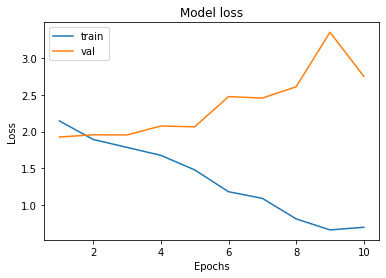

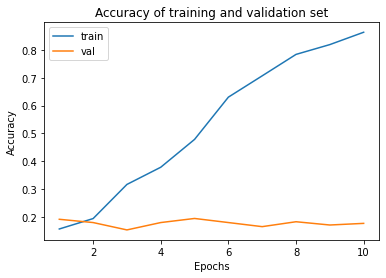

In [6]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing functions


test individual participant

In [ ]:
P40_acc = open_pickle('/content/drive/MyDrive/Sam/File_saved/P40_acc.pickle')
P40_markers = open_pickle('/content/drive/MyDrive/Sam/File_saved/P40_markers.pickle')

In [ ]:
P40_test = regroup_other(P40_markers,P40_acc)

In [ ]:
P40_test = reframe(P40_markers,P40_test)

In [ ]:
P40_other_test = P40_test[(P40_test['Label'] == 'Other')]

In [ ]:
P40_other_all_test = other_class(P40_other_test)

In [ ]:
P40_test = P40_test.drop(P40_test[(P40_test['Label'] == 'Do not use')].index)

In [ ]:
P40_test = P40_test.drop(P40_test[(P40_test['Label'] == 'Other')].index)

In [ ]:
P40_test = pd.concat([P40_test, P40_other_all_test], ignore_index = True)

In [ ]:
P40_test = P_standardize(P40_test)

In [ ]:
P40_test, P40_class = label_encoder(P40_test)
P40_class

array(['BH', 'OT', 'Other', 'Pass', 'Rest', 'SS', 'WS'], dtype=object)

In [ ]:
P40_test

,Pelvis x,Pelvis y,Pelvis z,T8 x,T8 y,T8 z,Head x,Head y,Head z,Right Shoulder x,...,Left Upper Leg x,Left Upper Leg y,Left Upper Leg z,Left Lower Leg x,Left Lower Leg y,Left Lower Leg z,Left Foot x,Left Foot y,Left Foot z,Label
0,-0.012811,-0.834734,0.266150,-0.342421,-0.745011,1.247579,-0.596391,-0.576118,1.275779,-0.801651,...,-0.191769,-0.987954,0.191211,-1.600948,-0.466518,0.075872,-1.489268,-0.616966,-0.018075,5
1,-0.083418,-0.168207,0.060670,-0.428481,-0.400516,1.269019,-0.675801,-0.277131,1.324614,-0.877495,...,-0.301009,-0.584807,0.252421,-1.617153,-0.320023,-0.199683,-1.501047,-0.225163,0.544058,5
2,-0.782921,1.079603,0.161623,-0.791063,0.620505,0.958737,-1.125888,0.719725,1.075327,-1.271942,...,-0.756622,0.357313,-0.103088,-1.976295,0.316768,-0.643768,-1.836560,0.263355,0.583146,5
3,-0.111430,1.224918,-0.623599,-0.129362,0.651779,-0.105367,-0.509408,0.692847,0.152693,-0.742937,...,-0.279365,0.232317,-1.370888,-1.766330,0.095990,-1.474088,-1.660382,0.334846,0.240702,5
4,-0.215446,0.685218,-0.312202,-0.426718,0.150832,0.448697,-0.840482,0.108579,0.620437,-1.030919,...,-0.608924,-0.505708,-1.204505,-2.250221,-0.552029,-1.309141,-1.961102,0.124973,0.235345,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48379,-0.020894,-0.024745,-0.019698,-0.010999,-0.014013,-0.026565,0.024310,0.008471,-0.027901,0.013841,...,-0.009700,-0.008335,-0.027464,-0.001923,-0.036317,-0.018765,-0.008000,-0.026140,0.005231,2
48380,0.028849,-0.033143,0.019821,0.041587,-0.019724,-0.002743,0.059451,0.004490,0.004090,0.046774,...,0.030826,-0.023581,0.004094,0.024248,-0.048531,0.005332,0.014865,-0.028826,0.017078,2
48381,0.047593,-0.009518,0.036193,0.085053,0.005135,0.012309,0.072544,0.025004,0.015402,0.069395,...,0.041379,-0.002775,0.018281,0.031733,-0.031485,0.013289,0.028966,-0.015905,0.020538,2
48382,0.026058,-0.022560,0.018199,0.083183,0.013864,0.005474,0.071777,0.023490,0.003097,0.044332,...,0.041689,-0.005529,0.033043,0.025137,-0.023893,0.021537,0.017082,-0.019597,0.022188,2


test reshape

In [ ]:
P123 = tf.concat([P01,P02,P03], axis=1)
P123.shape

TensorShape([576, 255, 52])

In [ ]:
P123_shuffle = tf_shuffle_axis(P123[:,:,0:52], axis=1)

In [ ]:
P123_shuffle.shape

TensorShape([576, 255, 52])

In [ ]:
X_P123 = (P123_shuffle[:,:,0:51]).numpy()
X_reshape_P123 = X_P123.reshape((P123_shuffle.shape[1],576, 51))

In [ ]:
X_reshape_P123.shape

(255, 576, 51)

In [ ]:
y_P123 = P123_shuffle[:,:,51].numpy() 
label_P123 = y_P123[0]

# Dictionnary

In [13]:
dct = {'P01_acc':P01_acc,'P01_markers':P01_markers,'P02_acc':P02_acc,'P02_markers':P02_markers,'P03_acc':P03_acc,'P03_markers':P03_markers}

In [16]:
dct['P01_acc']

,Frame,Pelvis x,Pelvis y,Pelvis z,T8 x,T8 y,T8 z,Head x,Head y,Head z,...,Left Upper Leg x,Left Upper Leg y,Left Upper Leg z,Left Lower Leg x,Left Lower Leg y,Left Lower Leg z,Left Foot x,Left Foot y,Left Foot z,Label
0,0,-0.000099,0.000712,-0.001159,0.246312,0.497346,-0.011794,0.345373,0.292784,0.172301,...,0.197891,-0.037716,-0.172511,0.441520,0.708759,-0.073357,0.267160,0.507843,-0.020744,Do not use
1,1,0.085870,-0.087079,-0.057492,0.270516,0.329011,-0.041490,0.342595,0.234431,-0.069587,...,0.286065,-0.283458,-0.174133,0.460206,0.508014,-0.051261,0.277574,0.392253,-0.037118,Do not use
2,2,0.043551,0.023407,0.000055,0.144880,0.406876,-0.017420,0.333028,0.329907,0.038479,...,0.222336,-0.221622,-0.120159,0.261654,0.588018,0.066416,0.195962,0.589012,0.046372,Do not use
3,3,-0.052281,0.032851,0.023840,0.005390,0.444358,0.020782,0.121774,0.415970,-0.086135,...,0.159082,-0.272581,-0.061035,0.051586,0.487235,0.108227,-0.042877,0.572785,0.003310,Do not use
4,4,0.005050,0.062071,0.025009,0.033177,0.315881,-0.070002,0.261215,0.304412,-0.195614,...,0.200309,-0.383079,-0.046320,-0.065462,0.314675,0.132233,0.055484,0.435952,-0.003216,Do not use
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398051,398051,0.109546,-0.192590,-0.019474,-0.016441,0.767020,-0.752473,1.434921,-0.467081,-1.171233,...,2.588507,6.441144,4.806530,-3.295399,1.378654,5.273978,-1.511757,2.380366,2.058949,Do not use
398052,398052,0.225429,-0.056844,0.079336,0.204197,0.582222,-0.461302,1.589540,-0.450009,-0.790704,...,2.863125,6.368722,3.993892,-3.239406,0.794041,5.558134,-1.645143,2.114684,2.426376,Do not use
398053,398053,0.027821,-0.216023,-0.066449,0.153890,0.150679,-0.402773,1.425629,-0.744814,-0.667597,...,2.182594,4.981315,2.295814,-3.370394,0.431018,5.052170,-1.888646,1.568463,2.351394,Do not use
398054,398054,-0.662307,-0.298908,-0.416978,-0.398631,-0.325173,-0.665061,0.774213,-1.156998,-0.832347,...,0.371587,2.671983,0.513763,-4.072240,0.520759,3.967976,-2.509244,1.009905,2.074472,Do not use


In [17]:
dct.keys()

dict_keys(['P01_acc', 'P01_markers', 'P02_acc', 'P02_markers', 'P03_acc', 'P03_markers'])